# **Récolte des données** 

### TODO : 

 - Finir la description pour les section V et VI
 - Faire une présentation générale au début du NB sur comment celui-ci marche.
 - Changer tous les liens de la section I car tous erronés sauf pour Aix Marseille
 - Retravailler les cellules markdown et les commentaires Python
 - Restructurer les paramètres
 - Pouvoir demander une liste de catégories

### Importation des librairies utiles

In [ ]:
import requests
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns

### I. Création du dictionnaire des Localisation avec leur URL respectives

Dans la cellule qui suit, nous récupérons le nom et les statistiques de toutes les villes recensées sur l'application Vigilio.

Puis nous stockons ces informations (uniquement les villes) dans une structure nommée DataFrame de python. Qui est une structure de données bidimensionnelle avec des colonnes de types différents.

In [ ]:
#Localisation des données
dict_association_localisation = {"AIX MARSEILLE PROVENCE METROPOLE":'https://vigilo.velosenville.org/get_issues.php?',
                                 "BASSIN D'ARCACHON":'https://vigilo.velobassin.org/get_issues.php?',
                                 "BEAUVAISIS":'https://vigilo.vellovaque.fr/get_issues.php?',
                                 "BORDEAUX MÉTROPOLE":'https://vigilo.cycles-manivelles.org/get_issues.php?',
                                 "BREST MÉTROPOLE":'https://vigilo.bapav.org/get_issues.php?',
                                 "EVREUX":'https://vigilo.cube27.org/get_issues.php?',
                                 "GRAND MONTPELLIER":'https://vigilo.jesuisundesdeux.org/get_issues.php?',
                                 "LA ROCHELLE":'https://vigilo.-lr.corolo.fr/get_issues.php?',
                                 "LORIENT AGGLO":'https://vigilo.claav.fr/get_issues.php?',
                                 "MONS":'https://vigilo.geckonline.be/get_issues.php?',
                                 "NANCY AGGLOMÉRATION":'https://vigilo.rigelk.eu/get_issues.php?',
                                 "NANTES MÉTROPOLE":'https://vigilo.placeauvelo-nantes.fr/get_issues.php?',
                                 "NORD-ISÈRE (APIE)":'https://vigilo.apie-asso.net/get_issues.php?',
                                 "PARIS SACLAY":'https://api.vigilo-parissaclay.mdb-idf.org/get_issues.php?',
                                 "PAYS DE CHÂTEAUGIRON":'https://pouliquen.net/vigilo/get_issues.php?',
                                 "PÉRIGUEUX AGGLO":'https://vigilo.velorution-perigourdine.fr/get_issues.php?',
                                 "SAINT MARCELLIN VERCORS ISÈRE COMMUNAUTÉ":'https://vigilo.roulavelo.org/get_issues.php?',
                                 "SAINT-BRIEUC ARMOR AGGLOMÉRATION":'https://api-vigilo.velo-utile.fr/get_issues.php?',
                                 "STRASBOURG":'https://www.strasbourgavelo.eu/get_issues.php?',
                                 "SUD OISE":'https://vigilo.au5v.fr//get_issues.php?',
                                 "THAU":'https://prod-sete.vigilo.velocite-montpellier.fr/get_issues.php?',
                                 "VANNES":'https://vigilo.kaz.bzh/get_issues.php?'
                                }

df_localisation = pd.DataFrame(dict_association_localisation.keys(), columns=["Localisation"])
df_localisation.set_index("Localisation", inplace=True)
df_localisation

""
Localisation
AIX MARSEILLE PROVENCE METROPOLE
BASSIN D'ARCACHON
BEAUVAISIS
BORDEAUX MÉTROPOLE
BREST MÉTROPOLE
EVREUX
GRAND MONTPELLIER
LA ROCHELLE
LORIENT AGGLO


### II. Création du dictionnaire avec les différentes catégories de signalements et leur numéro

Cette cellule utilise le module requests pour effectuer une requête HTTP vers une API et récupérer une liste de catégories. 

Ensuite, elle convertit cette liste en un dictionnaire et crée un DataFrame à partir de ce dictionnaire. Le DataFrame affiche les identifiants et les noms des catégories.

In [ ]:
# URL de l'API pour récupérer la liste des catégories
url_categories = 'https://vigilo-bf7f2.firebaseio.com/categorieslist.json'
resp = requests.get(url_categories)
resp.raise_for_status()

# Convertir la liste de catégories en un dictionnaire avec le nom de la catégorie comme clé et l'identifiant de catégorie comme valeur
categories_dict = {str(cat["catid"]): cat["catname"] for cat in resp.json()}

# Créer un dataframe à partir du dictionnaire
df_categories = pd.DataFrame(categories_dict.items(), columns=["id", "Catégories"]).set_index("id")

# Afficher le dataframe
df_categories

,Catégories
id,
8,Absence d'aménagement
3,Aménagement mal conçu
4,Défaut d'entretien
5,Absence d'arceaux de stationnement
2,Véhicule ou objet gênant
9,"Accident, chute, incident"
6,"Signalisation, marquage"
7,Incivilité récurrente sur la route
10,Vol ou dégradation de vélo


### III. Liste des POI

Dans la cellule qui suit, nous récupérons l'ensemble des points d'intérêts qui sont disponibles sur Vigilo
pour une ville donnée.

Puis nous stockons ces informations dans un DataFrame de python.

In [ ]:
# Créer un dictionnaire des points d'intérêt et leur identifiant OSM (ex: pour les parkings à vélo : "amenity:bicycle_parking")

poi_dict = {
    "Écoles": "amenity=school",
    "Hôpitaux": "amenity=hospital",
    "Parkings à vélos": "amenity=bicycle_parking",
    "Stations de vélos en libre-service": "amenity=bicycle_rental",
    "Passages piétons": "highway=crossing",
    "Feux piétons": "highway=traffic_signals",
    "Places": "highway=pedestrian",
    "Rampes d'accès pour handicapés": "amenity=wheelchair_ramp",
    "Sièges pour handicapés": "amenity=wheelchair_seating",
    "Parkings pour handicapés": "amenity=parking_space",
    "Parcs": "leisure=park",
    "Jardins": "leisure=garden",
    "Terrains de jeux": "leisure=playground",
    "Toilettes publiques": "amenity=toilets",
    "Fontaines à eau": "amenity=drinking_water",
    "Marchés": "amenity=marketplace",
    "Supermarchés": "shop=supermarket",
    "Boulangeries": "shop=bakery",
    "Pharmacies": "amenity=pharmacy",
    "Bibliothèques": "amenity=library",
    "Bureaux de poste": "amenity=post_office",
    "Stations de recharge pour véhicules électriques": "amenity=charging_station",
    "Cliniques": "amenity=clinic",
    "Dentistes": "amenity=dentist",
    "Vétérinaires": "amenity=veterinary",
    "Points de vue": "tourism=viewpoint",
    "Hôtels": "tourism=hotel",
    "Aires de pique-nique": "leisure=picnic_table",
    "Écoles maternelles": "amenity=kindergarten",
    "Écoles primaires": "amenity=primary_school",
    "Écoles secondaires": "amenity=secondary_school"
}

# Créer un dataframe à partir du dictionnaire
df_poi = pd.DataFrame(poi_dict.items(), columns=["Points d'intérêt", "Identifiant OSM"])

# Changer l'index
df_poi = df_poi.set_index("Identifiant OSM")

# Afficher le dataframe
df_poi

,Points d'intérêt
Identifiant OSM,
amenity=school,Écoles
amenity=hospital,Hôpitaux
amenity=bicycle_parking,Parkings à vélos
amenity=bicycle_rental,Stations de vélos en libre-service
highway=crossing,Passages piétons
highway=traffic_signals,Feux piétons
highway=pedestrian,Places
amenity=wheelchair_ramp,Rampes d'accès pour handicapés
amenity=wheelchair_seating,Sièges pour handicapés


### IV. Initialisation des paramètres

La présente section vous permet de choisir les différents paramètres que vous pouvez customiser afin d'effectuer votre requête.

- Définissez la boîte de recherche, pour cela, choississez sur 'site' un point au centre de l'endroit qui vous intéresse (centre de la ville) et entrez la latitude et la longitude de ce point dans central_lat et central_lon respectivement

1. Choisissez une localisation parmi celles proposées dans la liste

    >Pour accéder à la liste des localisations possibles il faut se référer à l'output de la section II.
    
    >Pour que la saisie soit valide merci d'indiquer la localisation entre guillemets : ex `"NOM LOCALISATION"`.

In [ ]:
# Filtre de recherche par localisation, exemple : location_filter = "BREST MÉTROPOLE"
location_filter = "BREST MÉTROPOLE"

2. Choisissez une date de début ainsi qu'une date de fin

    >Vérifier à ce que la date de début soit bien inférieur à la date de fin
    
    >Pour que la saisie soit valide merci d'indiquer la date avec le format suivant : `"YYYY-MM-DD"`.

In [ ]:
# FIltre de recherche par date, exemple : date_filter = "2021-01-01" dans le format "YYYY-MM-DD hh:mm:ss"
date_debut = "2000-01-01 00:00:00"
date_fin = "2024-12-31 23:59:59"

3. Choisissez une catégorie parmi celles proposées dans la liste

    >Pour accéder à la liste des catégories possibles il faut se référer à l'output de la section III.
    
    >Pour que la saisie soit valide merci d'indiquer l'identifiant de la catégorie (**et non le nom de celle-ci**) entre guillemets : ex `"8"` (pour indiquer la catégorie Absence d'aménagement).

In [ ]:
# Filtre des catégories à afficher, exemple : category_filter = "8" donne la catégorie Absence d'aménagement
category_filter = None

4. Choisissez un ou plusieurs points d'intérêt (POI) parmi ceux proposés dans la liste

    >Pour accéder à la liste des catégories possibles il faut se référer à l'output de la section VI.
    
    >Pour que la saisie soit valide merci d'indiquer les POIs entre guillemets, puis le tout entre crochets : ex `["Écoles", "Parkings à vélos"]`

In [ ]:
# # Filtre des points d'intérêt à afficher, exemple : poi_filter = "Parking à vélo" donne le point d'intérêt Parking à vélo
poi_names = ["Écoles", "Écoles maternelles", "Écoles primaires", "Écoles secondaires"]

### V. Création du dataframe des données

Dans la cellule qui suit, nous récupérons l'ensemble des points d'intérêts qui sont disponibles sur Vigilo
grâce à une requête vers leur API.

La requête est composée des paramètres initialisés dans la cellule précédente.

Un formatage spécifique est réservé pour les données en temps que l'on récupère afin qu'elles soient 
lisibles et exploitables par la suite.

Puis certaines des informations sont renommées et d'autres sont supprimées afin de n'avoir que les informations
ayant une plus value pour l'utilisateur.

In [ ]:
def data_collection(location_filter, category_filter, date_debut=None, date_fin=None):
    try:
        # Construct the URL for the API call
        url = dict_association_localisation[location_filter] + ('&c=' + category_filter if category_filter is not None else '')
        resp = requests.get(url)
        resp.raise_for_status()  # Raises an exception for HTTP errors

        # Load data into DataFrame
        df = pd.DataFrame(resp.json())

        # Ensure 'time' column is treated as integer for Unix timestamp conversion
        # Explicitly cast to integer before conversion
        df['time'] = pd.to_datetime(df['time'].astype(int), unit='s')

        # Convert datetime back to Unix timestamp for comparison (if filtering is needed)
        if date_debut is not None and date_fin is not None:
            date_debut_dt = pd.to_datetime(date_debut).timestamp()
            date_fin_dt = pd.to_datetime(date_fin).timestamp()
            df = df[(df['time'].astype('int64') // 10**9 >= date_debut_dt) & 
                    (df['time'].astype('int64') // 10**9 <= date_fin_dt)]

        return df

    except requests.exceptions.RequestException as e:
        print(f"Error fetching data: {e}")
        return None
    except ValueError as e:
        print(f"Error parsing JSON or date conversion issue: {e}")
        return None
df = data_collection(location_filter, category_filter, date_debut, date_fin)
df.rename(columns={"coordinates_lat": "latitude", "coordinates_lon": "longitude"}, inplace=True)
df.drop(columns=["status", "group", "approved"], inplace=True)

Error fetching data: 504 Server Error: Gateway Timeout for url: https://vigilo.kaz.bzh/get_issues.php


AttributeError: 'NoneType' object has no attribute 'rename'

### Aperçu des données récoltées

In [ ]:
df.head()

,token,latitude,longitude,address,comment,explanation,time,categorie,cityname
0,28B1750A,43.4450763505721,3.7585962563753124,"Boulevard de la République, Frontignan","gare, manque d'attache vélo et garage vélo",,2022-10-19 05:52:00,5,Frontignan
1,8A8F44A3,43.45232891265903,3.759173937141895,"Avenue de la Résistance, Frontignan",piste cyclable terminant sur trottoir et sans ...,,2022-08-15 07:25:00,3,Frontignan
2,5FDDE387,43.44130124701994,3.7594367936253548,"Avenue du 81ème Régiment d'Infanterie, Frontignan",Potelet bois cassé risque de crevaison,,2022-03-15 16:32:00,4,Frontignan
3,4D089813,43.42258851486555,3.722332119941711,"Avenue André Malraux, Frontignan",manque l'indication vers Balaruc,,2022-03-05 11:14:00,6,Frontignan
4,5C37467C,43.42728057159448,3.727451451122761,"Avenue du Maréchal Juin, Frontignan",indication pour aller à Sète ou Balaruc,,2022-02-27 11:42:00,6,Frontignan


### VI. Récupération des données OpenStreetMap autour de la région cherchée

TODO : refaire description

Cette cellule contient du code qui utilise les packages pandas, requests et json pour récupérer des points d'intérêt (POI) à partir d'une API Overpass. Les POI sont filtrés en fonction d'une zone géographique définie par les coordonnées bbox. Les données récupérées sont ensuite traitées et stockées dans un dataframe pandas.

In [ ]:
#Boîte de recherche pour les points d'intérêt en prenant les moyennes des latitudes et longitudes des données
df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')
central_lat = df['latitude'].mean()
df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')
central_lon = df['longitude'].mean()
delta = 0.02

bbox = (central_lat - delta, central_lon - delta, central_lat + delta, central_lon + delta)

def fetch_poi_data(bbox, poi_names, poi_dict):
    # Prepare the Overpass query part for multiple POI tags
    query_parts = []
    for poi_name in poi_names:
        poi_tag = poi_dict.get(poi_name)
        if poi_tag is None:
            raise ValueError(f"Le point d'intérêt '{poi_name}' n'est pas reconnu.")
        # Format tag correctly for the Overpass query
        formatted_poi_tag = poi_tag.replace("=", '="') + '"'
        query_part = f"""
            node[{formatted_poi_tag}](bbox:{bbox[0]},{bbox[1]},{bbox[2]},{bbox[3]});
            way[{formatted_poi_tag}](bbox:{bbox[0]},{bbox[1]},{bbox[2]},{bbox[3]});
            rel[{formatted_poi_tag}](bbox:{bbox[0]},{bbox[1]},{bbox[2]},{bbox[3]});
        """
        query_parts.append(query_part)
    
    # Combine all query parts
    full_query = f"""
    [out:json];
    (
        {''.join(query_parts)}
    );
    out center;
    """
    
    # Define the Overpass API URL
    url = "http://overpass-api.de/api/interpreter"

    # Send the request to the Overpass API
    response = requests.get(url, params={'data': full_query})
    response.raise_for_status()  # Raises an HTTPError for bad responses
    return response.json()

def process_poi_data(json_data):
    # Initialize a dictionary to hold all POIs
    poi_dict = {}
    
    # Go through each element in the JSON data
    for element in json_data['elements']:
        # Check if the element is a node and has the required 'tags'
        if element['type'] == 'node' and 'tags' in element:
            # Check if the latitude and longitude are within the bounding box
            if bbox[0] <= element['lat'] <= bbox[2] and bbox[1] <= element['lon'] <= bbox[3]:
                poi_info = {
                    'name': element['tags'].get('name', 'Unknown'),
                    'latitude': element.get('lat', None),
                    'longitude': element.get('lon', None),
                    }
                
                # Add this POI's information to the main dictionary
                poi_dict[element['id']] = poi_info
            
    return poi_dict

pois_json = fetch_poi_data(bbox, poi_names, poi_dict)
pois = process_poi_data(pois_json)
df_poi = pd.DataFrame.from_dict(pois, orient='index')

In [ ]:
df_poi.head()

""


### VII. Sauvegarde des données Vigilo et OpenStreetMap

Cette cellule stocke sous la forme de CSV les données récoltées (points d'intérêt et signalements).
Elle prend aussi en compte le type de système d'exploitation utilisé pour adapter le chemin en conséquence.

In [ ]:
# Get the absolute path to this working directory
cheminAbs = os.getcwd().split(os.path.sep)

# Change the path to the directory CSV
cheminAbs[len(cheminAbs)-1] = "CSV"
chemin = os.path.sep.join(cheminAbs)

# Saving the data to a CSV file in the data_analysis folder
df.to_csv(os.path.join(chemin, "df_incidents.csv"))
df_poi.to_csv(os.path.join(chemin, "df_poi.csv"))


# **Annexe**

## Nombre de signalements par catégorie 
(Si le graphique le s'affiche pas, vous changez le filtre de catégorie en **None**)

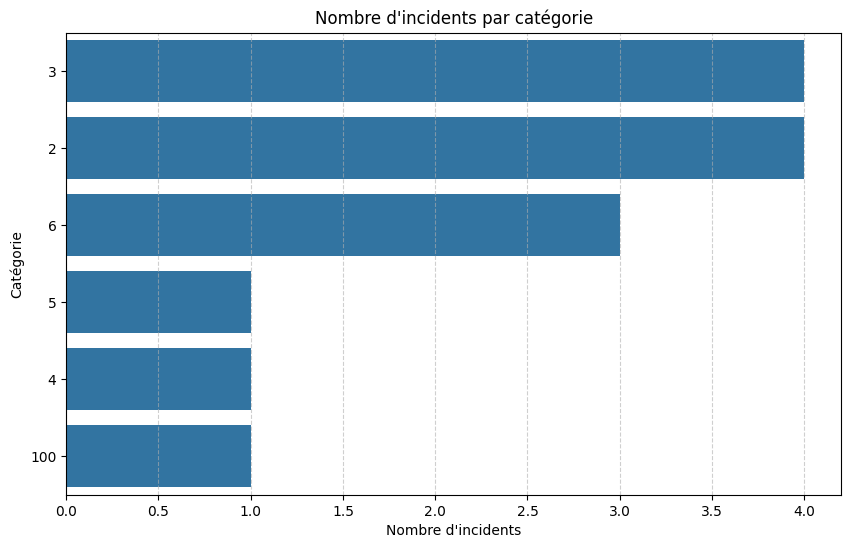

In [ ]:
if category_filter == None:
    # Counting the number of incidents per category
    df['categorie'].value_counts()

    # Plotting the number of incidents per category

    plt.figure(figsize=(10, 6))
    sns.countplot(y='categorie', data=df, order=df['categorie'].value_counts().index)
    plt.title("Nombre d'incidents par catégorie")
    plt.xlabel("Nombre d'incidents")
    plt.ylabel("Catégorie")
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.show()
else : 
    print("Changez la valeur de category_filter à None pour afficher le graphique des incidents par catégorie")